In [1]:
# packages?
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.utils import resample
from sklearn.decomposition import PCA


In [2]:
# 1 data exploratory
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Load in dataset
train_data = pd.read_csv('train_2025_2026.csv')
print(train_data.head())

# Missing values summary
missing_by_column = train_data.isnull().sum()
columns_with_missing = missing_by_column[missing_by_column > 0]
print(f"\nColumns with missing values: {len(columns_with_missing)}")
print(f"Columns without missing values: {len(train_data.columns) - len(columns_with_missing)}")

# Row-level missing info
rows_with_any_missing = train_data.isnull().any(axis=1).sum()
rows_with_all_missing = train_data.isnull().all(axis=1).sum()
rows_with_half_missing = (train_data.isnull().sum(axis=1) > train_data.shape[1]//2).sum()

print(f"Rows with any missing values: {rows_with_any_missing} ({rows_with_any_missing/len(train_data)*100:.1f}%)")
print(f"Rows with all values missing: {rows_with_all_missing} ({rows_with_all_missing/len(train_data)*100:.1f}%)")
print(f"Rows with >50% values missing: {rows_with_half_missing} ({rows_with_half_missing/len(train_data)*100:.1f}%)")

print("\nMissing value patterns (first 10 columns with most missing):")
missing_analysis = pd.DataFrame({
    'Missing_Count': train_data.isnull().sum(),
    'Missing_Percentage': (train_data.isnull().sum() / len(train_data)) * 100
}).sort_values('Missing_Count', ascending=False)
print(missing_analysis.head(10))

# Class proportions
print("\n" + "="*50)
print("Proportion of classes in data")
class_counts = train_data['Outcome'].value_counts()
class_proportions = train_data['Outcome'].value_counts(normalize=True) * 100
print("Absolute counts:")
print(class_counts)
print("\nProportions (%):")
print(class_proportions)

# Correlation matrix
corr_matrix = train_data.corr()
print(corr_matrix)

print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS SUMMARY")
print("="*50)
print(f"Dataset: {train_data.shape[0]} rows, {train_data.shape[1]} columns")
print(f"Total missing values: {train_data.isnull().sum().sum()}")



EXPLORATORY DATA ANALYSIS
   Gene 1  Gene 2  Gene 3   Gene 4  Gene 5  Gene 6  Gene 7  Gene 8  Gene 9  \
0     NaN   133.0    75.0  12971.0   401.0   296.0   348.0  1087.0  4224.0   
1     5.0   127.0    85.0  15875.0   285.0   305.0   298.0  1297.0  2090.0   
2     5.0    81.0   133.0      NaN   228.0   387.0   465.0  2657.0  3653.0   
3     5.0    75.0     NaN  17527.0   467.0   242.0   392.0  3482.0  3408.0   
4     4.0    74.0   103.0  13053.0   329.0     NaN   357.0  2714.0  2739.0   

   Gene 10  ...  Gene 1993  Gene 1994  Gene 1995  Gene 1996  Gene 1997  \
0      NaN  ...      101.0    16517.0      308.0      100.0      235.0   
1      8.0  ...       64.0    17950.0      458.0      191.0      137.0   
2     32.0  ...      138.0    11715.0      181.0      161.0      261.0   
3     59.0  ...       88.0    12420.0      403.0      114.0      290.0   
4     75.0  ...      129.0    11697.0      205.0      102.0      269.0   

   Gene 1998  Gene 1999  Gene 2000  Outcome    Id  
0      

In [3]:
# Guided Exercise 2: Undersampling to balance classes
from sklearn.utils import resample
imbalanced_data = pd.read_csv('train_2025_2026.csv')

class_counts = imbalanced_data['Outcome'].value_counts()
print(class_counts)
num_min = min(class_counts)
print('Number of samples of the class with fewer samples:', num_min)

balanced_list = []
for class_ in imbalanced_data['Outcome'].unique():
    df_class = imbalanced_data[imbalanced_data['Outcome'] == class_]
    df_resampled = resample(df_class, replace=False, n_samples=num_min, random_state=42)
    balanced_list.append(df_resampled)

balanced_data = pd.concat(balanced_list)
print('New class distribution:\n', balanced_data['Outcome'].value_counts())
balanced_data.to_csv('training_balanced_data.csv', index=False)


Outcome
3    1280
2     881
1     730
0     629
Name: count, dtype: int64
Number of samples of the class with fewer samples: 629
New class distribution:
 Outcome
3    629
0    629
2    629
1    629
Name: count, dtype: int64


In [5]:
# Guided exercise 3:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
import pandas as pd

data = pd.read_csv('training_balanced_data.csv')
X = data.drop(columns=['Outcome', 'Id'])
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = make_pipeline(SimpleImputer(), StandardScaler(), LogisticRegression(max_iter=1000, penalty = None))
model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_prob = model.predict_proba(X_train)
y_test_prob = model.predict_proba(X_test)

roc_train = roc_auc_score(y_train, y_train_prob, multi_class='ovr')
roc_val = roc_auc_score(y_test, y_test_prob, multi_class='ovr')

f1_train = f1_score(y_train, y_train_pred, average='macro')
f1_val = f1_score(y_test, y_test_pred, average='macro')

print(f"Training ROC AUC: {roc_train:.4f}")
print(f"Validation ROC AUC: {roc_val:.4f}")
print(f"Training Macro F1: {f1_train:.4f}")
print(f"Validation Macro F1: {f1_val:.4f}")

'''
Explanation of the metrics:

ROC AUC one-versus-rest basically performs a normal ROC AUC for binary classification, which basically compares the performance
of the model regarding true positive rate and false positive rate over all posible thresholds. But in this case, as we are in a
multiclasification task, this AUC will be the average of comparing each class against all other classes togheter as if they 
formed a new class all toghether.

Macro F1 is like a plain F1 in binary classification, where precission and recall are taken into acount and the average is done in a one-versus-rest 
as with the ROC AUC.
'''
'''
The impute and scaling of the data can't be done before the spliting of the training and validation data because then we would be imputing and
scaling taking into acount the average of all data including the one that will be used for testing, which will actually give information to the model
of the validation data and thus the generalisation poerformance accuracy will be compromised.
'''


Training ROC AUC: 1.0000
Validation ROC AUC: 0.9408
Training Macro F1: 1.0000
Validation Macro F1: 0.7940


"\nThe impute and scaling of the data can't be done before the spliting of the training and validation data because then we would be imputing and\nscaling taking into acount the average of all data including the one that will be used for testing, which will actually give information to the model\nof the validation data and thus the generalisation poerformance accuracy will be compromised.\n"

In [6]:
# Guided exercise 4:
from sklearn.impute import KNNImputer

model = make_pipeline(StandardScaler(), KNNImputer(n_neighbors=3), LogisticRegression(penalty=None))

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_prob = model.predict_proba(X_train)
y_test_prob = model.predict_proba(X_test)

roc_train = roc_auc_score(y_train, y_train_prob, multi_class='ovr')
roc_val = roc_auc_score(y_test, y_test_prob, multi_class='ovr')

f1_train = f1_score(y_train, y_train_pred, average='macro')
f1_val = f1_score(y_test, y_test_pred, average='macro')

print(f"Training ROC AUC: {roc_train:.4f}")
print(f"Validation ROC AUC: {roc_val:.4f}")
print(f"Training Macro F1: {f1_train:.4f}")
print(f"Validation Macro F1: {f1_val:.4f}")


'''
In this case, we first need to scale the data as the imputer algorithm uses euclidian distances to find the nearest neighbor in the data space,
taking into acount all the dimensions, and so it's necessary to scale the data so not one feature has more weight than another when 
computing which is the nearest neighbour.
'''

Training ROC AUC: 1.0000
Validation ROC AUC: 0.9478
Training Macro F1: 1.0000
Validation Macro F1: 0.8139


"\nIn this case, we first need to scale the data as the imputer algorithm uses euclidian distances to find the nearest neighbor in the data space,\ntaking into acount all the dimensions, and so it's necessary to scale the data so not one feature has more weight than another when \ncomputing which is the nearest neighbour.\n"

In [5]:
# Guided exercise 5:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer


data = pd.read_csv('training_balanced_data.csv')
X = data.drop(columns=['Outcome', 'Id'])
y = data['Outcome']

modelreg = make_pipeline(StandardScaler(), KNNImputer(n_neighbors=3), LogisticRegression(C = 1))
modelnoreg = make_pipeline(StandardScaler(), KNNImputer(n_neighbors=3), LogisticRegression(penalty=None))

scoring = {
    'roc_auc_ovr': make_scorer(roc_auc_score, multi_class='ovr', response_method='predict_proba'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_resultsreg = cross_validate(modelreg, X, y, cv=cv, scoring=scoring)
cv_resultsnoreg = cross_validate(modelnoreg, X, y, cv=cv, scoring=scoring)


roc_aucreg = np.mean(cv_resultsreg['test_roc_auc_ovr'])
f1_macroreg = np.mean(cv_resultsreg['test_f1_macro'])
roc_aucnoreg = np.mean(cv_resultsnoreg['test_roc_auc_ovr'])
f1_macronoreg = np.mean(cv_resultsnoreg['test_f1_macro'])


print(f"Average 10-fold ROC AUC (OvR) regularized model: {roc_aucreg:.4f}")
print(f"Average 10-fold F1 macro regularized model: {f1_macroreg:.4f}")
print(f"Average 10-fold ROC AUC (OvR) non regularized model: {roc_aucnoreg:.4f}")
print(f"Average 10-fold F1 macro non regularized model: {f1_macronoreg:.4f}")
print(f'ROC AUC difference Reg vs NonReg:{roc_aucreg-roc_aucnoreg:.4f}')
print(f'ROC AUC difference Reg vs NonReg:{f1_macroreg-f1_macronoreg:.4f}')


Average 10-fold ROC AUC (OvR) regularized model: 0.9427
Average 10-fold F1 macro regularized model: 0.7856
Average 10-fold ROC AUC (OvR) non regularized model: 0.9406
Average 10-fold F1 macro non regularized model: 0.7818
ROC AUC difference Reg vs NonReg:0.0021
ROC AUC difference Reg vs NonReg:0.0038


The variance explained by the PC1 and PC2 in %: [0.67 0.63]
Top features for PC: 
 PC1      Gene 113
PC2     Gene 1478
PC3     Gene 1882
PC4     Gene 1049
PC5      Gene 639
PC6      Gene 385
PC7      Gene 120
PC8     Gene 1924
PC9     Gene 1268
PC10     Gene 213
dtype: object


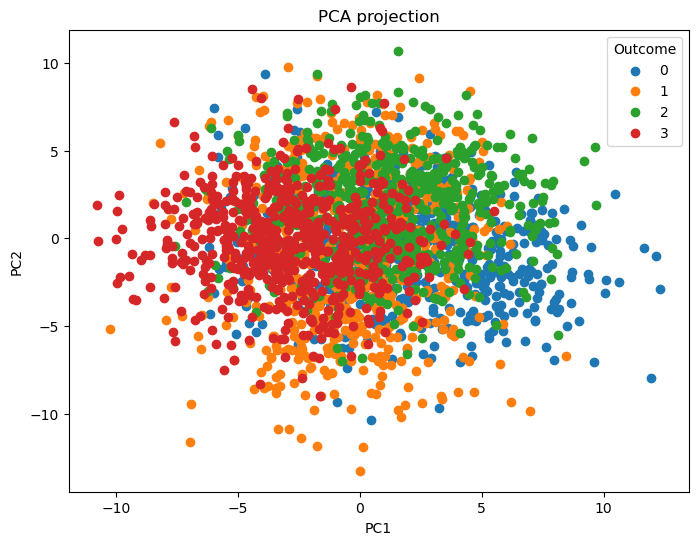

In [ ]:
# Guided exercise 6:
from sklearn.decomposition import PCA

data = pd.read_csv('training_balanced_data.csv')
X = data.drop(columns=['Outcome', 'Id'])
y = data['Outcome']
feature_names = X.columns.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
imputer = KNNImputer(n_neighbors=3)
X_imputed = imputer.fit_transform(X_scaled)

pca = PCA()
X_pca = pca.fit_transform(X_imputed)

#explained variance
explain_2PC = pca.explained_variance_ratio_[:2]
print(f'The variance explained by the PC1 and PC2 in %: {(100* explain_2PC).round(2)}')

#dataframe with top features per PC:
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=feature_names)
#just top feature per PC
top_features = loadings.abs().idxmax()

print(f'Top features for PC: \n {top_features[:10]}')

#Plot
plt.figure(figsize=(8,6))
for label in np.unique(y):
    plt.scatter(X_pca[y==label, 0], X_pca[y==label, 1], label=str(label))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA projection')
plt.legend(title = 'Outcome')  
plt.show()


In [9]:
#Guided exercise 7:

data = pd.read_csv('training_balanced_data.csv')
X = data.drop(columns=['Outcome', 'Id'])
y = data['Outcome']

model = make_pipeline(StandardScaler(), KNNImputer(n_neighbors=3), PCA(n_components=100), LogisticRegression(C = 1))

scoring = {
    'roc_auc_ovr': make_scorer(roc_auc_score, multi_class='ovr', response_method='predict_proba'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)

roc_auc = np.mean(cv_results['test_roc_auc_ovr'])
f1_macro = np.mean(cv_results['test_f1_macro'])


print(f"Average 10-fold ROC AUC (OvR) PCA regularized model: {roc_auc:.4f}")
print(f"Average 10-fold F1 macro PCA regularized model: {f1_macro:.4f}")
print(f'ROC AUC improvement PCA vs NonPCA:{((roc_auc-0.9427)/0.9427*100):.4f}%')
print(f'ROC AUC improvement PCA vs NonPCA:{((f1_macro-0.7856)/0.7856*100):.4f}%')

Average 10-fold ROC AUC (OvR) PCA regularized model: 0.9493
Average 10-fold F1 macro PCA regularized model: 0.8035
ROC AUC improvement PCA vs NonPCA:0.6961%
ROC AUC improvement PCA vs NonPCA:2.2784%
